# Market-implied stock price PDFs: risk-neutral and physical

Option prices embed information about the markets expectation of future performance of the underlying asset.
The set of European option prices across strikes for a given maturity $T$ implies a risk-neutral probability density function (details below) of the price $S_T$ of the underlying asset at the maturity.

This density reflects the distribution consistent with current option prices under the pricing measure that discounts payoffs at the risk-free rate.
It also reflects both how the market expects the underlying to move (although it is important to note that the pdf we obtain is NOT simply the market's prediction of where the stock is likely to move), as well as how the market prices risk across the various outcomes.

This project uses several years of daily SPX option chain data to extract the market-implied risk-neutral pdfs for options with 1 day maturities, 7 day maturities, and 28 day maturities.
Using the Breeden-Litzenberger relation, which says that the implied pdf is given by the second partial derivative of price at maturity with respect to strike:
$$ f_Q(K) = e^{rT} \frac{\partial^2 C(K, T)}{\partial K^2},$$
we numerically recover the pdf.
Since strikes come in discrete increments, we require some numerical techniques to interpolate.
We also need to smooth the data enough to take a second derivative.

I then discuss and compare ways of recovering the real-world probability distribution from the risk-neutral one.

There are two main goals of this project:
1. Compare the risk-neutral pdf to the realized price distribution.
2. Test a simple way of estimating the real-world density function from the risk-neutral density.

The secondary goal is to give exposition of the theory and background needed to understand this topic so that a wider audience may find it useful and engaging.


## Part 1: risk-neutral distributions

### Theoretical Background

#### Risk-neutral probability measure

#### The Breeden-Litzenberger Formula
Recall that the fair value of a call option with time $\tau$ until expiry is the present value of the expected payoff.
If $f_Q$ denotes the PDF of the stock prices $S_T$ of some stock $S$ at time $T$ (with respect to the risk-neutral measure $Q$), this is
$$
\begin{align*}
C(K, \tau) &= e^{-rt} \mathbb E_Q(\max\{S_T - K, 0\}) \\
&= e^{-rt} \int_0^\infty \max\{x - K, 0\} f_Q(x) \, d x \\
&= e^{-rt} \int_K^\infty (x - K) f(x) \, dx.
\end{align*}
$$
To derive the Breeden-Litzenberger formula, we just need to invert this to find $f$ as a function of $C$.
Taking the partial derivative with respect to $K$ gives
$$
\begin{align*}
\frac{\partial C}{\partial K} &= - e^{-rt} \int_{K}^\infty f(x) \, dx \\
&= e^{-rt} \left( \int_{-\infty}^K f(x) \, dx - 1 \right),
\end{align*}
$$
where in the second step we use the fact that $\int_{\R} f(x) \, dx = 1$.
But now we can find $f$ by taking one more derivative.
Doing this and rearranging, we see that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}.$$

### Implementation

#### The data

I obtained my options chain data from OptionsDX.
I have EOD options chain data for SPX for years 2020 through 2023.
I filtered for options with 1 day maturities, 7 day maturities, and 28 day maturities, so that I can compare all the methods across a range of expiration lengths.
See `processing.ipynb` in the `data` directory for the code and more explanation of data preprocessing.

First I'll import the data and get it into the dataframes that I want.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import random
from black_scholes import *     # utility functions related to the Black-Scholes formula

from scipy.interpolate import CubicSpline # for cubic interpolation with smoothing
from scipy.interpolate import make_splrep

In [2]:
data_years = ["2020", "2021", "2022", "2023"]

spx_dfs = [
    pd.read_csv(f"data/spx_options_{year}.csv")
    for year in data_years
]

spx_df = pd.concat(spx_dfs, ignore_index=True).dropna()



numeric_cols = ['call_iv', 'call_last', 'put_last'] # TODO: and some more
for col in numeric_cols:
    spx_df[col] = pd.to_numeric(spx_df[col], errors="coerce")

print("This datatframe contains all the data that we'll use for this project.")
display(spx_df)

spx_1dte = spx_df[spx_df['tte_unix'] == 60*60*24]
spx_7dte = spx_df[spx_df['tte_unix'] == 60*60*24*7]
spx_28dte = spx_df[spx_df['tte_unix'] == 60*60*24*28]

# create a collection of dataframes, one for each day
spx_1dte_dfs = [
    spx_1dte[spx_1dte['quote_unix'] == utime]
    for utime in spx_1dte['quote_unix'].unique()
]

spx_7dte_dfs = [
    spx_7dte[spx_7dte['quote_unix'] == utime]
    for utime in spx_7dte['quote_unix'].unique()
]

spx_28dte_dfs = [
    spx_28dte[spx_28dte['quote_unix'] == utime]
    for utime in spx_28dte['quote_unix'].unique()
]

print("This dataframe corresponds to all the options on a given day with a given expiry date.")
display(spx_1dte_dfs[500])


This datatframe contains all the data that we'll use for this project.


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,tte_years,call_mid,put_mid
0,3002.74,1583355600,1583269200,2020-03-03 16:00:00,1800.0,4.69707,1200.81,1210.10,1210.60,2.00098,0.0,0.05,0.10,1.0,86400,0.002740,1205.455,0.025
2,3002.74,1583355600,1583269200,2020-03-03 16:00:00,1950.0,3.83174,1050.80,1060.11,0.00,1.70212,0.0,0.05,0.00,1.0,86400,0.002740,1055.455,0.025
5,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2100.0,3.09885,900.90,910.31,0.00,1.42364,0.0,0.05,0.05,1.0,86400,0.002740,905.605,0.025
9,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2300.0,2.26013,700.80,710.10,718.60,1.07846,0.0,0.04,0.15,1.0,86400,0.002740,705.450,0.020
13,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2450.0,1.74473,550.70,560.90,0.00,0.83460,0.0,0.05,0.05,1.0,86400,0.002740,555.800,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373997,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4275.0,0.13586,14.30,14.60,9.24,0.12984,167.9,170.50,295.83,28.0,2419200,0.076712,14.450,169.200
373998,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4280.0,0.13573,13.60,13.80,8.64,0.11912,170.7,172.50,0.00,28.0,2419200,0.076712,13.700,171.600
373999,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4285.0,0.13550,12.60,12.90,10.25,0.11255,174.6,176.50,202.50,28.0,2419200,0.076712,12.750,175.550
374000,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4290.0,0.13485,11.80,12.00,3.87,0.12305,180.2,182.90,345.00,28.0,2419200,0.076712,11.900,181.550


This dataframe corresponds to all the options on a given day with a given expiry date.


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,tte_years,call_mid,put_mid
336563,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4375.0,-0.00018,34.9,35.60,33.33,0.09861,1.55,1.65,1.65,1.0,86400,0.00274,35.250,1.60
336564,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4380.0,0.00009,30.6,31.30,29.25,0.09741,2.10,2.20,2.17,1.0,86400,0.00274,30.950,2.15
336565,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4385.0,0.04976,26.3,26.80,24.62,0.09583,2.85,2.95,3.40,1.0,86400,0.00274,26.550,2.90
336566,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4390.0,0.06293,22.3,22.80,20.67,0.09524,3.80,3.90,3.90,1.0,86400,0.00274,22.550,3.85
336567,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4395.0,0.06771,18.6,19.00,18.70,0.09492,5.00,5.20,5.10,1.0,86400,0.00274,18.800,5.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336619,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4900.0,0.47294,0.0,0.05,0.05,0.83751,489.20,491.70,0.00,1.0,86400,0.00274,0.025,490.45
336620,4410.22,1689105600,1689019200,2023-07-10 16:00:00,5000.0,0.55611,0.0,0.05,0.00,0.99638,588.90,591.70,630.73,1.0,86400,0.00274,0.025,590.30
336621,4410.22,1689105600,1689019200,2023-07-10 16:00:00,5200.0,0.71462,0.0,0.05,0.00,1.32352,788.80,791.70,0.00,1.0,86400,0.00274,0.025,790.25
336622,4410.22,1689105600,1689019200,2023-07-10 16:00:00,5400.0,0.86475,0.0,0.05,0.00,1.65199,988.80,991.70,0.00,1.0,86400,0.00274,0.025,990.25


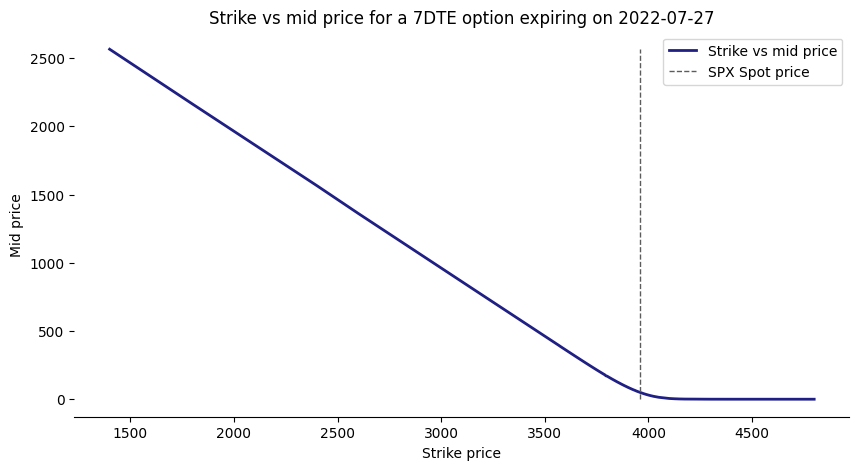

In [3]:
fig, ax = plt.subplots(figsize=(10,5))

# pick a random option chain to display (from the 7dte options)
df = spx_7dte_dfs[random.randint(0,len(spx_7dte_dfs)-1)].copy()
expire_date = pd.to_datetime(df['expire_unix'].mode()[0], unit="s").date()
plt.title(f"Strike vs mid price for a 7DTE option expiring on {expire_date}")

ax.plot(df['strike'], df['call_mid'], color="#1F1F84", linewidth=2, label=f"Strike vs mid price")
ax.vlines(df['underlying_last'].mean(), ymin=0, ymax=df['call_mid'].max(), color="#5C5C5C", linestyle="--", linewidth=1, label="SPX Spot price")

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("Strike price")
ax.set_ylabel("Mid price");
ax.legend();


Since the scale of this plot is large, this curve may appear smooth even when it contains small irregularities.
Extracting the implied probability density requires computing second derivatives, which will amplify any irregularities.
Due to this, we need to smooth this curve.
Also due to this, we should not try interpolating/smoothing directly on this data; the second derivative will be highly unstable.

A more robust approach is to convert the prices to implied volatilities using Black-Scholes, perform the interpolation in volatility space, and then convert back to prices.
In fact, we'll do one more step: after we obtain implied volatility as a function of strike price, we'll convert it to a function of log-moneyness (roughly, this is just the log of the strike price), *then* do the smoothing, and then convert back.

The example below illustrates the problem with trying to smooth prices directly.


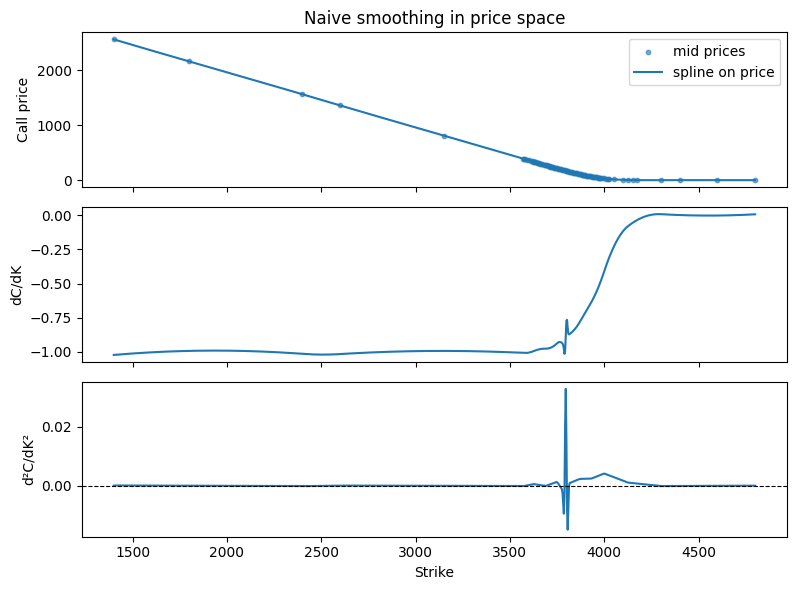

In [ ]:
from scipy.interpolate import UnivariateSpline

# Assume df already exists with columns 'strikes' and 'call_mid'

# 1. Extract and clean data
K = df["strike"].to_numpy()
C_mid = df["call_mid"].to_numpy()

mask = np.isfinite(K) & np.isfinite(C_mid)
K = K[mask]
C_mid = C_mid[mask]

order = np.argsort(K)
K = K[order]
C_mid = C_mid[order]

smoothing = 0.05 * len(K)

price_spline = UnivariateSpline(K, C_mid, k=3, s=smoothing)

K_fine = np.linspace(K.min(), K.max(), 1000)
C_smooth = price_spline(K_fine)

dC_dK = np.gradient(C_smooth, K_fine)
d2C_dK2 = np.gradient(dC_dK, K_fine)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].scatter(K, C_mid, s=10, alpha=0.6, label="mid prices")
axes[0].plot(K_fine, C_smooth, label="spline on price", linewidth=1.5)
axes[0].set_ylabel("Call price")
axes[0].legend()
axes[0].set_title("Naive smoothing in price space")

axes[1].plot(K_fine, dC_dK, linewidth=1.5)
axes[1].set_ylabel("C'(K)")

axes[2].plot(K_fine, d2C_dK2, linewidth=1.5)
axes[2].axhline(0.0, color="black", linestyle="--", linewidth=0.8)
axes[2].set_ylabel("C''(K)")
axes[2].set_xlabel("Strike")

plt.tight_layout()
plt.show()


In the following cell, we define functions that convert the price data to implied volatility, perform a smoothed interpolation, convert back to price, and then compute the second derivative.

In [6]:


from scipy.interpolate import make_splrep, interp1d

def compute_implied_vols(strikes, prices, spot, T, option_type, r=0.0):
    strikes = np.asarray(strikes)
    prices = np.asarray(prices)

    iv_list = []
    strikes_list = []

    for k, c in zip(strikes, prices):
        try:
            iv = bs_implied_volatility(
                option_type=option_type,
                market_price=c,
                S0=spot,
                K=k,
                t=T,
                r=r,
            )
        except Exception:
            continue

        if iv is None or not np.isfinite(iv):
            continue

        strikes_list.append(k)
        iv_list.append(iv)

    strikes_valid = np.array(strikes_list)
    iv_valid = np.array(iv_list)

    # plt.plot(strikes_valid, iv_valid)
    # plt.title('strikes_valid vs iv_valid from compute_implied_vols()')
    # plt.show()

    order = np.argsort(strikes_valid)
    return strikes_valid[order], iv_valid[order]

def fit_iv_logmoneyness(strikes, iv, forward, smoothing_factor=None):
    """
    Fit a smooth implied vol curve as a function of log-moneyness lm = log(strike/F),
    enforcing positivity by fitting log(iv) and exponentiating.

    Returns iv as a function of strike and the domain of the fitted curve.
    """
    strikes = np.asarray(strikes)
    iv = np.asarray(iv)

    lm_vals = np.log(strikes/forward)

    iv = np.maximum(iv, 1e-4)
    log_iv = np.log(iv)

    # sort by lm for a well-behaved spline
    order = np.argsort(lm_vals)
    lm_sorted = lm_vals[order]
    log_iv_sorted = log_iv[order]
    strikes_sorted = strikes[order]

    if smoothing_factor is None:
        n = len(lm_vals)
        smoothing_factor = 0.01 * n

    # spline in log-moneyness space
    spline_log_iv = make_splrep(
        lm_sorted,
        log_iv_sorted,
        k=3,
        s=smoothing_factor,
    )

    # --- function of STRIKE, wrapping log-moneyness ---
    def iv_of_strike(K):
        K = np.asarray(K)
        lm = np.log(K / forward)
        log_iv_val = spline_log_iv(lm)      # spline is defined in lm-space
        return np.exp(log_iv_val)     

    # spline_log_iv = make_splrep(lm_vals, log_iv, k=3, s=smoothing_factor)

    # iv_of_lm = lambda lm: np.exp(spline_log_iv(lm))

    K_grid = np.linspace(strikes_sorted.min(), strikes_sorted.max(), 500)
    # plt.scatter(strikes_sorted, iv[order], s=10, label="data")
    # plt.plot(K_grid, iv_of_strike(K_grid), label="spline IV(K)")
    # plt.title("Strike vs IV (smoothed via log-moneyness)")
    # plt.legend()
    # plt.show()



    # plt.plot(lm_vals, iv_of_lm(lm_vals))
    # plt.title("log moneyness vs iv(lm) smoothed from fit_iv_logmoneyness()")
    # plt.show()

    return iv_of_strike, K_grid
    

def smooth_option_curve(strikes, option_prices, spot, T, option_type, r=0, forward=None, n_grid=500, smoothing_factor=None):
    strikes = np.asarray(strikes)
    option_prices = np.asarray(option_prices)

    # in a few dataframes there are large gaps here

    order = np.argsort(strikes)
    strikes = strikes[order]
    option_prices = option_prices[order]

    diffs = np.diff(strikes)
    typical_step = np.median(diffs)  # robust estimate

    # Define a uniform strike grid between min and max
    strike_fine = np.arange(strikes.min(), strikes.max() + typical_step, typical_step)

    # linearly interpolate option prices
    interp_func = interp1d(strikes, option_prices, kind='linear', fill_value="extrapolate")
    option_prices_interp = interp_func(strike_fine)

    strikes = strike_fine
    option_prices = option_prices_interp
 
    # plt.plot(strikes, option_prices)
    # plt.scatter(strikes, option_prices)
    # plt.title("strikes vs option prices from smooth_option_curve after interpolation")
    # plt.show()

    # calculate iv on observed strikes
    strikes_obs, iv_obs = compute_implied_vols(
        strikes=strikes,
        prices=option_prices,
        spot=spot,
        T=T,
        option_type=option_type,
        r=r,
    )

    # plt.plot(strikes_obs, iv_obs)
    # plt.title("observed strikes vs obs iv")
    # plt.show()

    if forward is None:
        forward = spot * np.exp(r * T)

    # fit IV(lm)
    iv_of_strike, strike_grid = fit_iv_logmoneyness(
        strikes=strikes_obs,
        iv=iv_obs,
        forward=forward,
        smoothing_factor=smoothing_factor
    )

    # plt.plot(strike_grid, iv_of_strike(strike_grid))
    # plt.title("iv(lm) from smooth_option_curve")
    # plt.show()

    # make a fine grid in lm and map back to strike
#     lm_min, lm_max = lm_vals.min(), lm_vals.max()
#     lm_grid = np.linspace(lm_min, lm_max, n_grid)
#     strike_grid = forward * np.exp(lm_grid)

#     def iv_of_strike(strike):
#         strike = np.asarray(strike)
#         lm = np.log(strike / forward)
#         return iv_of_lm(lm)

#     iv_smooth = iv_of_lm(lm_grid)
# V    iv_smooth = np.maximum(iv_smooth, 1e-5)

    # plt.plot(lm_grid, iv_smooth)
    # plt.title("lm_grid vs iv_smooth")
    # plt.show()

    # plt.plot(strike_grid, iv_of_strike(strike_grid))
    # plt.title("strike vs iv smoothed from smooth_option_curve()")
    # plt.show()

    # convert back to prices via Black–Scholes
    price_smooth = np.array([
        bs_price(
            S0=spot,
            K=strike_grid[i],
            sigma=iv_of_strike(strike_grid)[i],
            t=T,
            r=r,
            option_type=option_type,
        )
        for i in range(len(strike_grid))
    ])
    
    return strike_grid, price_smooth, iv_of_strike

def create_pdf_from_df(df: pd.DataFrame, option_type):

    strike_grid, price_smooth, iv_of_strike = smooth_option_curve(
        strikes = df['strike'],
        option_prices = df[f'{option_type}_mid'],
        spot = df['underlying_last'].mean(), # this column should be constant but we'll take the mean anyway
        T = df['tte_years'].iloc[0],
        option_type = option_type,
    )
    
    f = np.gradient(price_smooth, strike_grid)
    f_2 = np.gradient(f, strike_grid)


    # ensure nonnegative and normalize
    f_2 = np.clip(f_2, 0, None)
    area = np.trapezoid(f_2, strike_grid)
    # print(f"area of f_2: {area}")
    if area > 0:
        f_2 /= area


    # return strikes_fine, bs_prices_fine, CubicSpline(strikes_fine, f_2)
    return strike_grid, price_smooth, CubicSpline(strike_grid, f_2)


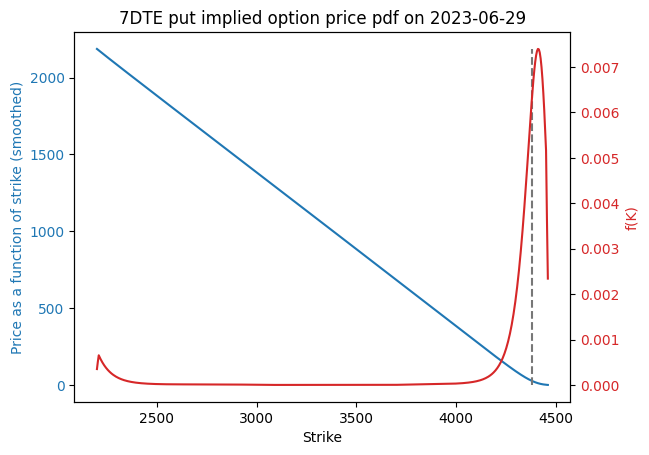

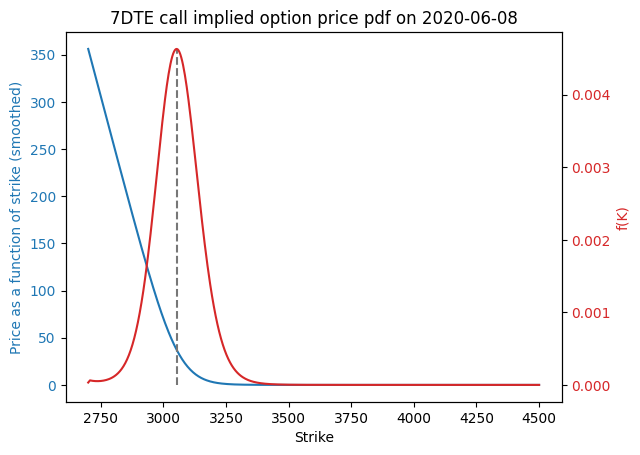

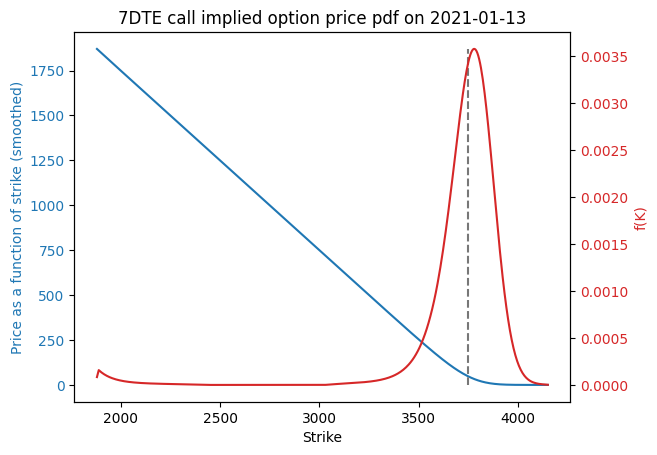

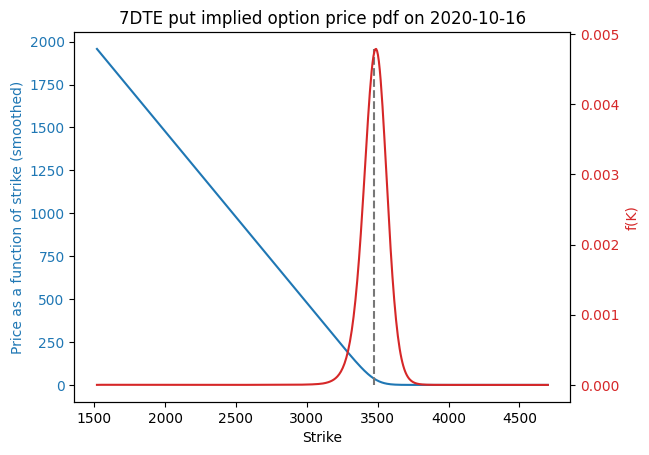

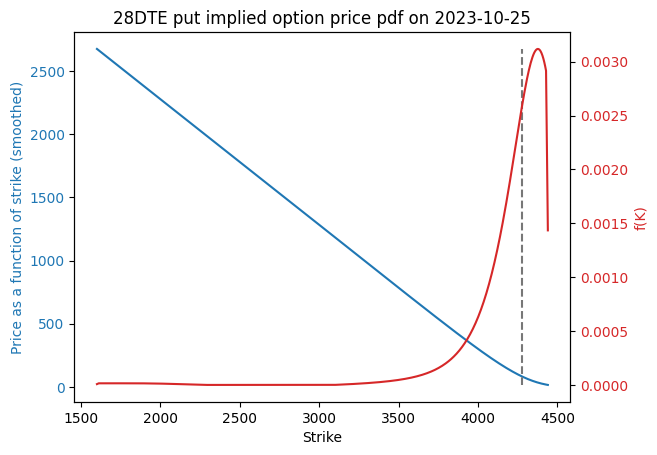

In [7]:


for _ in range(5):
    dfs = {
        "1DTE": spx_1dte_dfs,
        "7DTE": spx_7dte_dfs,
        "28DTE": spx_28dte_dfs,
    }

    df_type = random.choice(["1DTE", "7DTE", "28DTE"])
    df = dfs[df_type][random.randint(0, len(dfs[df_type]))].copy()

    # for i, search_df in enumerate(spx_1dte_dfs):
    #     if "2021-11-29 16:00:00" in search_df["quote_time"].values:
    #         print(f"Found in dataframe {i}")
    #         df = search_df
    #         break

    # df = spx_1dte_dfs[14]


    # df = spx_28dte_dfs[random.randint(0, len(spx_1dte_dfs))].copy()

    spot_price = df['underlying_last'].mean()   # I am taking the mean just in case, but the underlying_last column should contain only one number

    option_type = ["call", "put"][random.randint(0,1)]

    # strikes_fine, bs_prices_fine, f_2 = create_pdf(
    #     option_type=option_type, # TODO: also do put options
    #     strikes=df['strike'],
    #     option_prices=df[f'{option_type}_mid'],
    #     underlying_prices=df["underlying_last"],
    #     tte_years=tte_years,
    #     spot_price=spot_price
    # )

    # plt.plot(df['strike'], df['call_mid'])
    # plt.title("strike vs mid")
    # plt.show()

    strike_grid, price_smooth, iv_smooth = smooth_option_curve(
        strikes=df['strike'],
        option_prices=df['call_mid'],
        spot=spot_price,
        T=df['tte_years'].iloc[0],
        option_type="call",
        r=0,
        n_grid=500,
    )

    # plt.plot(strike_grid, price_smooth)
    # plt.title("strike vs price NEW smoothed")
    # plt.show()

    # plt.plot(strike_grid, iv_smooth(strike_grid))
    # plt.title("strike vs iv NEW smoothed")
    # plt.show()

    # plt.plot(df['strike'], df['call_iv'])
    # plt.title("strike vs iv")
    # plt.show()
    
    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, 'call')

    # plt.plot(strikes_fine, bs_prices_fine)
    # plt.title("strikes fine vs bs prices fine")
    # plt.show()


    fig, ax1 = plt.subplots()

    ax1.plot(strikes_fine, bs_prices_fine)
    ax1.set_xlabel('Strike')
    ax1.set_ylabel('Price as a function of strike (smoothed)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(strikes_fine, f_2(strikes_fine), color='tab:red', label='pdf')
    ax2.set_ylabel('f(K)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # print(f_2(strikes_fine).min())
    ax1.vlines(x=spot_price, ymin=bs_prices_fine.min(), ymax=bs_prices_fine.max(), color="#777777", linestyles="--", label="Spot price")
    # ax1.vlines(x=spot_price * np.exp(0.5 * tte_years), ymin=bs_prices_fine.min(), ymax=bs_prices_fine.max(), color="#777777", linestyles="--", label="Spot price")
    plt.title(f"{df_type} {option_type} implied option price pdf on {pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date()}")
    plt.show()



Now we need to do a little numeric differentiation to apply the Breeden-Litzenberger formula, which we recall from the discussion above says that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}$$


## Comparing to market data

The method that we'll use to evaluate the accuracy of the predictions is called the **continuous ranked probability score.**
It is defined by
$$ C(D, y) = \int_{\R} (F_D(x) - \mathbf 1_{x \geq y})^2 \, dx, $$
where
- $F_D$ is the cumulative distribution function of the forecasted distribution $D$,
- $\mathbf 1_{x \geq y}$ is the indicator function, which is 1 if $x \geq y$ and 0 otherwise, and
- $y \in \R$ is the observation.

I will evaluate this integral numerically to assign a score to the predicted pdfs.
It is not hard to see by looking at the definition that a lower score is better, with 0 being the lowest possible score, which can only be achieved by the distribution that assigns probability 1 to the observed outcome, and 0 to all other outcomes.
In general, this score rewards some combination of both precision and accuracy.



We'll start by downloading the SPX data for the same range that we have option data.

In [8]:
earliest_day = pd.to_datetime(spx_df['quote_unix'].min(), unit="s")
latest_day = pd.to_datetime(spx_df['expire_unix'].max(), unit="s")

spx_data = yf.download("^SPX", start=earliest_day, end=latest_day, auto_adjust=True)
display(spx_data)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
2020-01-09,3274.699951,3275.580078,3263.669922,3266.030029,3641230000
...,...,...,...,...,...
2024-01-22,4850.430176,4868.410156,4844.049805,4853.419922,4297610000
2024-01-23,4864.600098,4866.479980,4844.370117,4856.799805,3912800000


Now we implement the CRPS function described above, and a function that will calculate the CRPS given a dataframe of option data.

In [9]:

def crps(D_pdf, y, min_input, max_input, n_samples=500):
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a given predictive
    distribution and observation, when D_pdf is a *pdf* on [min_input, max_input].

    Parameters
    ----------
    D_pdf : callable
        Probability density function f(x) of the predictive distribution.
        It must be (approximately) supported on [min_input, max_input].
    y : float
        Observed value.
    min_input : float
        Lower bound of the domain where the pdf is non-negligible.
    max_input : float
        Upper bound of the domain where the pdf is non-negligible.
    n_samples : int, optional
        Number of grid points used for numerical integration.

    Returns
    -------
    float
        Approximate CRPS(F, y).
    """
    # Create a grid on the domain
    z = np.linspace(min_input, max_input, int(n_samples))
    dz = z[1] - z[0]

    # Evaluate the pdf on the grid and clip in case of numerical errors
    f = np.asarray(D_pdf(z), dtype=float)
    f = np.clip(f, 0.0, np.inf)

    # # Normalize f - actually I think this is always taken care of in other steps
    # norm = np.trapezoid(f, z)
    # if norm <= 0:
    #     raise ValueError("PDF integrates to zero or negative over the given bounds.")
    # f /= norm

    # Build the CDF via cumulative sum
    F = np.cumsum(f) * dz
    # Clip for numerical safety so CDF stays in [0, 1]
    F = np.clip(F, 0.0, 1.0)

    # CRPS integral: \int (F(z) - 1_{z >= y})^2 dz
    indicator = (z >= y).astype(float)
    integrand = (F - indicator) ** 2
    crps_val = np.trapezoid(integrand, z)

    return float(crps_val)


def evaluate_rn_option_prediction_from_df(df: pd.DataFrame, option_type):
    """
    Given a dataframe, construct the risk-neutral implied pdf of option prices at the expiry date of the options in the frame.
    Then look up the actual price of SPX at close on the day of expiration and use CRPS to score the prediction.
    """
    
    expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())
    spx_price_on_expiry_date = spx_data.loc[expiry_date, "Close"].iloc[0]

    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, option_type)
    
    return crps(f_2, spx_price_on_expiry_date, strikes_fine.min(), strikes_fine.max())

In [ ]:

print("Calculating CRPS scores...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
    c = 0
    p = 0
    for df in df_type:
        
        call_score = evaluate_rn_option_prediction_from_df(df, 'call')
        put_score = evaluate_rn_option_prediction_from_df(df, 'put')
        c += call_score
        p += put_score

    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE calls: {c / len( df_type ) :.2f}")
    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE puts: {p / len( df_type ) :.2f}")


Calculating CRPS scores...
Average CRPS for 1 DTE calls: 29.44
Average CRPS for 1 DTE puts: 25.92
Average CRPS for 7 DTE calls: 58.10
Average CRPS for 7 DTE puts: 55.92


/home/steven/.pyenv/versions/.env/lib/python3.12/site-packages/scipy/interpolate/_fitpack_repro.py:700: RuntimeWarning: error. a theoretically impossible result was found during
the iteration process for finding a smoothing spline with
fp = s. probably causes : s too small.
there is an approximation returned but the corresponding
weighted sum of squared residuals does not satisfy the
condition abs(fp-s)/s < tol.

  _ = root_rati(f, p, bracket, acc)


By themselves these numbers are too abstract to be useful; it isn't clear what constitutes a good or bad score.
We can get some intuition for the meaning of the scores with the following code.
This code calculates the hypothetical scenario in which the stock price at the expiry of the option turns out to be the price that maximizes the density function for the market-implied probability distribution.

We'll also find these numbers useful for comparison in the next section where we test a method of converting the risk-neutral density to real-world density.

In [ ]:
from scipy.optimize import minimize_scalar

print("Calculating CRPS scores in the hypothetical case that all predictions turn out to be correct...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
    s = 0
    for df in df_type:
        expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())

        strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, 'call')
        max_probability_price = minimize_scalar( lambda x: -f_2(x), bounds=(strikes_fine.min(), strikes_fine.max()), method='bounded').x
        
        score = crps(f_2, max_probability_price, strikes_fine.min(), strikes_fine.max())
        if score > 150:
            print(f"Maybe some bad data in {df['dte'].iloc[0]} DTE calls quoted on {df['quote_time']}")
            plt.plot(strikes_fine, f_2(strikes_fine))
            plt.show()
            plt.plot(strikes_fine, bs_prices_fine)
            plt.show()
        s += score                             

    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE calls if all predictions were correct: {s / len( df_type ) :.2f}")

# Part 2: converting the risk-neutral density to a real-world density

As discussed before, the density that we are extracting from the option prices is not just purely the market's prediction of where the stock is likely to move.
So far I have obtained a density $f_Q$ for the risk-neutral probability measure $Q$, and I would like to convert this to a density $f_P$ for the real-world probability measure $P$.
In general there is not an obvious way to do this.

Recall our previous calculation that

\begin{align*}
C(K, T) &= e^{-rT} \mathbb E_Q(\max\{S_T - K, 0\}) \\
&= e^{-rT} \int_0^\infty \max\{x - K, 0\} f_Q(x) \, d x
\end{align*}
We can continue this:
\begin{align*}
\qquad \qquad \qquad \quad &= e^{-rT} \int_0^\infty \max\{x - K, 0\} \frac{f_Q(x)}{f_P(x)} f_P(x) \, dx \\
&= \mathbb E_P[ \max\{S_T - K, 0\} \cdot m(S_T) ],
\end{align*}
where $m(S_T)$ is a random variable called the *stochastic discount factor*, and is defined by the equation above, so that
$$
m(S_T) = e^{-r T} \frac{f_Q(S_T)}{f_P(S_T)}
$$


In [ ]:


def physical_density_from_rn(fQ, s_min, s_max, n_grid=500, gamma=4):
    """
    Convert a callable risk-neutral pdf fQ(s) into a callable physical pdf fP(s)
    under a CRRA/power-utility assumption with coefficient gamma.

    Parameters
    ----------
    fQ : callable
        Function fQ(s): risk-neutral pdf (should integrate ≈ 1 over its support).
    s_min, s_max : float
        Bounds of the support (integration domain).
    n_grid : int, optional
        Number of grid points used for numerical integration and interpolation (default 500).
    gamma : float, optional
        Coefficient of relative risk aversion (default 4).

    Returns
    -------
    fP_func : callable
        Function fP(s): normalized physical (real-world) pdf.
    s_grid : ndarray
        Grid used for normalization and interpolation.
    fP_grid : ndarray
        Values of fP(s) on that grid.

    Notes
    -----
    f_P(s) = (s^gamma / E_Q[S_T^gamma]) * f_Q(s)
    
    """
    # 1. Construct grid and evaluate fQ on it
    s_grid = np.linspace(s_min, s_max, n_grid)
    fQ_grid = fQ(s_grid)
    fQ_grid = np.clip(fQ_grid, 0, None)  # remove tiny negatives

    # 2. Compute normalization constant E_Q[S_T^gamma]
    Z = np.trapezoid((s_grid ** gamma) * fQ_grid, s_grid)

    # 3. Compute unnormalized fP
    fP_grid = (s_grid ** gamma) * fQ_grid / Z

    # normalize
    norm = np.trapezoid(fP_grid, s_grid)
    if norm > 0:
        fP_grid /= norm

    # 5. Return a callable spline for fP
    fP_func = CubicSpline(s_grid, fP_grid, extrapolate=False)

    return fP_func, s_grid, fP_grid


def evaluate_physical_option_prediction_from_df(df: pd.DataFrame, option_type):
    """
    Given a dataframe, construct the risk-neutral implied pdf of option prices at the expiry date of the options in the frame.
    Then convert to a physical probability.
    Then look up the actual price of SPX at close on the day of expiration and use CRPS to score the prediction.
    """
 
    expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())
    spx_price_on_expiry_date = spx_data.loc[expiry_date, "Close"].iloc[0]


    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, option_type)
    fP, s_grid, fP_grid = physical_density_from_rn(f_2, strikes_fine.min(), strikes_fine.max())
    
    return crps(fP, spx_price_on_expiry_date, strikes_fine.min(), strikes_fine.max())



# test this out
for _ in range(10):
    df = random.choice(spx_28dte_dfs) # choose a random df
    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, "call")
    fP, s_grid, fP_grid = physical_density_from_rn(f_2, strikes_fine.min(), strikes_fine.max())
    plt.plot(strikes_fine, f_2(strikes_fine))
    plt.plot(strikes_fine, fP(strikes_fine))
    plt.show()

    print(evaluate_rn_option_prediction_from_df(df, 'call'))
    print(evaluate_physical_option_prediction_from_df(df, 'call'))


In [ ]:


print("Starting to calculate CRPS for implied real-world probability distributions...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
# for df_type in [spx_1dte_dfs]:
    s = 0
    for df in df_type:

        score = evaluate_physical_option_prediction_from_df(df, 'call')

        s += score
        # historical_scores.append(score)
        # historical_times.append(df['quote_unix'].iloc[0])
                                 

    print(f"Average CRPS for implied physical probability densities of calls in {int(df_type[0]['dte'].iloc[0])}: {s / len( df_type )}")
print("Done.")
    # print(f"Average CRPS for implied physical probability densities of calls in {int(df_type[0]['dte'].iloc[0])}: {s / 10}")




# References and further reading

Here I have collected some sources of information for this project, as well as some interesting resources related to the topics discussed.

### **Market-implied probabilities**

[Are market implied probabilities useful?](https://blog.thinknewfound.com/2017/11/market-implied-probabilities-useful/) - A blog post.

[A blog post titled "Options Implied Distributions are NOT Real-World Distributions"](https://freeportlogbook.substack.com/p/options-implied-distributions-are) - A blog post.

### **Estimating real-world probabilities from option-implied risk-neutral probabilities**

[Steve Ross: The Recovery Theorem.](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.12092) - A theorem about recovering the real-world probability distribution from the market-implied one.

[Does the Ross recovery theorem work empirically?](https://www.sciencedirect.com/science/article/abs/pii/S0304405X20300763) - An article that gives some evidence that the Ross recovery theorem may break down in the real world.

[Estimating the real-world density from the option-implied risk-neutral density.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2093397) - A paper.

[Quant stackexchange.](https://quant.stackexchange.com/questions/50700/what-is-the-connection-between-the-risk-neutral-implied-density-and-the-real-wor/50701#50701) - A post about estimating the implied real-world density from option prices.


[Bakshi, Kapadia, and Madan (2003) risk-neutral moment estimators: A Gram–Charlier density approach](https://link.springer.com/article/10.1007/s11147-022-09187-x)

### **Other topics**

[Wikipedia article on scoring rules](https://en.wikipedia.org/wiki/Scoring_rule).
These are rules that are used to assign a score to a predicted probability distribution and an observed value; exactly what we are doing to compare the risk-neutral distributions to real market movements.


[Stephen Taylor: Asset Prices Dynamics, Volatility, and Prediction.](https://ia801604.us.archive.org/20/items/quant_books/Asset%20Price%20Dynamics%2C%20Volatility%20_%20Prediction%20-%20S.%20J.%20Taylor.pdf) - A really good book about a lot of different topics related to this project.
In particular see chapter 16: Density Prediction for Asset Prices, and section 16.9: From Risk-Neutral to Real-World Densities